In [1]:
import io 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ssv2.simulation import BaseSimulation

Let's start by visualizing some little simulations.

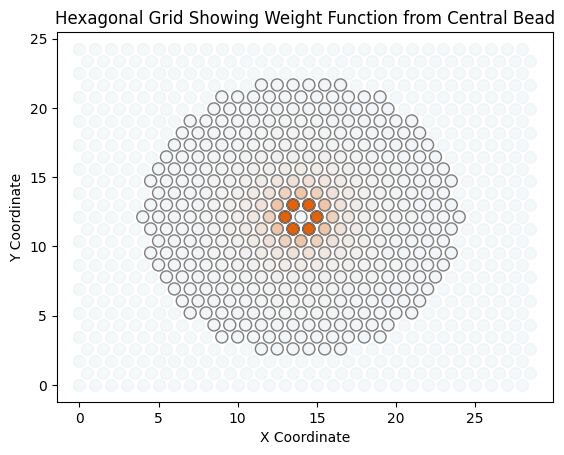

In [2]:
simulator = BaseSimulation(29, 29)

simulator.plot_setting()

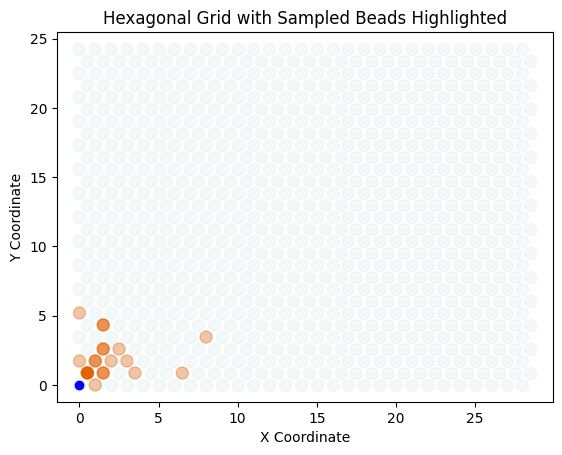

In [3]:
_ = simulator.plot_sample(20, 0)

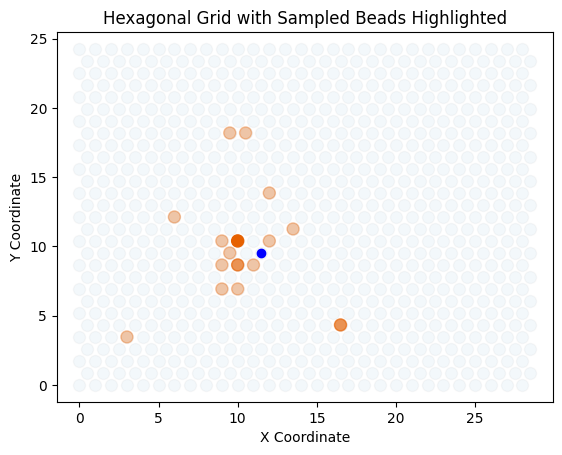

In [4]:
_ = simulator.plot_sample(20, 330)

In [5]:
from PIL import Image

# Generate frames
frames = []
for _ in range(20):
    # This assumes your plot_sample function returns a Figure object
    fig = simulator.plot_sample(200, 130)
    # Convert the Figure object to a PIL Image
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    frame = Image.open(buf)
    frames.append(frame)
    plt.close(fig)  # Close the figure after using it

# Save as an animated GIF
frames[0].save(
    'animation.gif',
    save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0
)

## Big simulation!

In [6]:
simulator = BaseSimulation(197, 197)

In [8]:
simulator.simulate_bead_dispersion(1000, 450)

,x_pos,y_pos,bead_counts
index,,,
48,48,0,1
49,49,0,2
50,50,0,3
52,52,0,3
53,53,0,9
...,...,...,...
2420,56,12,1
2425,61,12,1
2617,56,13,2


In [ ]:
simulated_beads_df = simulator.simulate_experiment(1000)

In [19]:
simulated_beads_df.to_csv('simulated_beads_1000.csv.gz', index=False, compression='gzip')


In [20]:
several_beads = simulated_beads_df[simulated_beads_df['source_bead'].isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]  

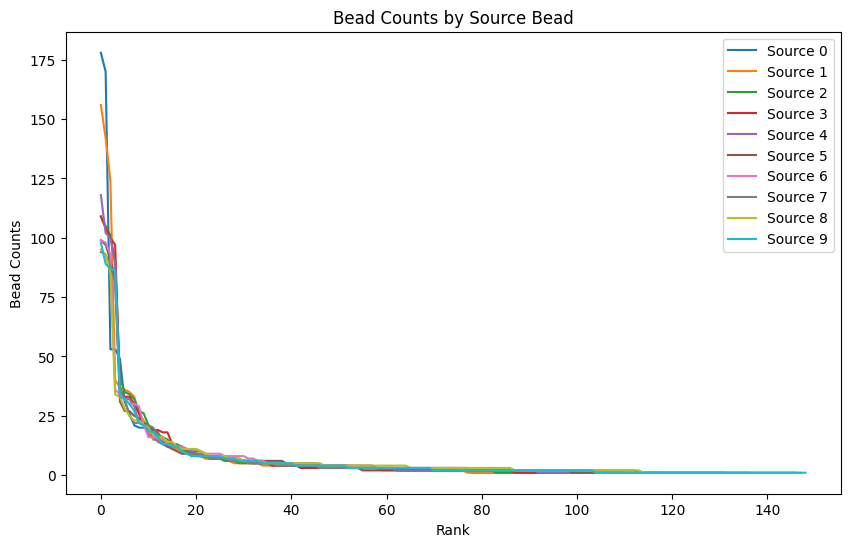

In [24]:
df = several_beads

# Plotting
plt.figure(figsize=(10,6))

for source, group in df.groupby('source_bead'):
    sorted_group = group.sort_values(by='bead_counts', ascending=False)
    plt.plot(sorted_group['bead_counts'].values, label=f'Source {source}')

plt.ylabel('Bead Counts')
plt.xlabel('Rank')
plt.title('Bead Counts by Source Bead')
plt.legend()
plt.show()